## Chicago Traffic Crashes


### Business Understanding

The end goal for this project is to minimize future crashes in the city of Chicago, and increase traffic safety, 
following the Data Scince Lifecycle: 
1. Business Understanding
2. Data Mining
3. Data Cleaning
4. EDA (Exploratory Data Analysis)
5. Feature Engineering
6. Predictive Modeling
7. Data Visualization

Considering our objective, the "most relevant" questions for the time being are:
- What is the main cause of crashes in the city of Chicago?
- How can they be avoided?
- In which areas do crashes occur the most?
- When do we have the most amount of crashes?
- What actions can we take to minimize the number of crashes as much as possible?

### Data Mining

#### Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar as cal
import logging
import plotly.express as px
import geopandas as gpd
import dash

#### Creating Dataframe

In [2]:
#~ Data Source: https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if
#~ Last Updated: 2024-03-04
#~ Data Owner: Chicago Police Department
all_data = pd.read_csv('Traffic_Crashes_-_Crashes_20240304.csv')
all_data.head()

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,23a79931ef555d54118f64dc9be2cf2dbf59636ce253f7...,NaN,09/05/2023 07:05:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DUSK,ANGLE,"FIVE POINT, OR MORE",...,2.0,0.0,2.0,0.0,19,3,9,NaN,NaN,NaN
1,2675c13fd0f474d730a5b780968b3cafc7c12d7adb661f...,NaN,09/22/2023 06:45:00 PM,50,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",REAR END,DIVIDED - W/MEDIAN BARRIER,...,0.0,0.0,2.0,0.0,18,6,9,NaN,NaN,NaN
2,5f54a59fcb087b12ae5b1acff96a3caf4f2d37e79f8db4...,NaN,07/29/2023 02:45:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),...,0.0,0.0,1.0,0.0,14,7,7,41.85412,-87.665902,POINT (-87.665902342962 41.854120262952)
3,7ebf015016f83d09b321afd671a836d6b148330535d5df...,NaN,08/09/2023 11:00:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,NOT DIVIDED,...,0.0,0.0,2.0,0.0,23,4,8,NaN,NaN,NaN
4,6c1659069e9c6285a650e70d6f9b574ed5f64c12888479...,NaN,08/18/2023 12:50:00 PM,15,OTHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,OTHER,...,1.0,0.0,1.0,0.0,12,6,8,NaN,NaN,NaN


### Data Cleaning

In [3]:
#~ Columns per missing data
for col in all_data.columns:
    print(f'Percentage of missing data in {col}: {all_data[col].isnull().sum()/all_data.shape[0]*100:.2f}%')

Percentage of missing data in CRASH_RECORD_ID: 0.00%
Percentage of missing data in CRASH_DATE_EST_I: 92.52%
Percentage of missing data in CRASH_DATE: 0.00%
Percentage of missing data in POSTED_SPEED_LIMIT: 0.00%
Percentage of missing data in TRAFFIC_CONTROL_DEVICE: 0.00%
Percentage of missing data in DEVICE_CONDITION: 0.00%
Percentage of missing data in WEATHER_CONDITION: 0.00%
Percentage of missing data in LIGHTING_CONDITION: 0.00%
Percentage of missing data in FIRST_CRASH_TYPE: 0.00%
Percentage of missing data in TRAFFICWAY_TYPE: 0.00%
Percentage of missing data in LANE_CNT: 75.46%
Percentage of missing data in ALIGNMENT: 0.00%
Percentage of missing data in ROADWAY_SURFACE_COND: 0.00%
Percentage of missing data in ROAD_DEFECT: 0.00%
Percentage of missing data in REPORT_TYPE: 2.96%
Percentage of missing data in CRASH_TYPE: 0.00%
Percentage of missing data in INTERSECTION_RELATED_I: 77.07%
Percentage of missing data in NOT_RIGHT_OF_WAY_I: 95.39%
Percentage of missing data in HIT_AND_RU

#### Drop columns with too much NaN values

In [4]:
#~ Taking in acount the Pareto Principle, we will drop the columns with more than 80% missing data:
columns_to_drop = []

for col in all_data.columns:
    if all_data[col].isnull().sum()/all_data.shape[0]*100 > 80:
        all_data.drop(col, axis=1, inplace=True)
        columns_to_drop.append(col)

#~ Columns dropped
print(f'Columns dropped: {columns_to_drop}')

Columns dropped: ['CRASH_DATE_EST_I', 'NOT_RIGHT_OF_WAY_I', 'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I']


#### New columns per missing data

In [5]:
columns_per_missing_data = {}
#~ New columns per missing data
for col in all_data.columns:
    columns_per_missing_data[col] = all_data[col].isnull().sum()/all_data.shape[0]*100
    
#~ Columns per missing data Ordered
columns_per_missing_data = dict(sorted(columns_per_missing_data.items(), key=lambda item: item[1], reverse=True))
for k, v in columns_per_missing_data.items():
    print(f'Percentage of missing data in {k}: {v:.2f}%')

Percentage of missing data in INTERSECTION_RELATED_I: 77.07%
Percentage of missing data in LANE_CNT: 75.46%
Percentage of missing data in HIT_AND_RUN_I: 68.71%
Percentage of missing data in REPORT_TYPE: 2.96%
Percentage of missing data in LATITUDE: 0.68%
Percentage of missing data in LONGITUDE: 0.68%
Percentage of missing data in LOCATION: 0.68%
Percentage of missing data in MOST_SEVERE_INJURY: 0.22%
Percentage of missing data in INJURIES_TOTAL: 0.22%
Percentage of missing data in INJURIES_FATAL: 0.22%
Percentage of missing data in INJURIES_INCAPACITATING: 0.22%
Percentage of missing data in INJURIES_NON_INCAPACITATING: 0.22%
Percentage of missing data in INJURIES_REPORTED_NOT_EVIDENT: 0.22%
Percentage of missing data in INJURIES_NO_INDICATION: 0.22%
Percentage of missing data in INJURIES_UNKNOWN: 0.22%
Percentage of missing data in BEAT_OF_OCCURRENCE: 0.00%
Percentage of missing data in STREET_DIRECTION: 0.00%
Percentage of missing data in STREET_NAME: 0.00%
Percentage of missing data

#### Analyzing relevance of columns with > 60% missing data

In [6]:
#~ INTERSECTION_RELATED_I: A field observation by the police officer whether an intersection played a role in the crash. 
#   Does not represent whether or not the crash occurred within the intersection.
#~ LANE_CNT: Total number of through lanes in either direction, excluding turn lanes, as determined by reporting officer (0 = intersection).
#~ HIT_AND_RUN_I: Crash did/did not involve a driver who caused the crash and fled the scene without exchanging information and/or rendering aid.

#~ Datatypes and values in each column
#~ INTERSECTION_RELATED_I
print(all_data['INTERSECTION_RELATED_I'].value_counts())
#~ LANE_CNT
print(all_data['LANE_CNT'].value_counts())
#~ HIT_AND_RUN_I
print(all_data['HIT_AND_RUN_I'].value_counts())

INTERSECTION_RELATED_I
Y    177146
N      8822
Name: count, dtype: int64
LANE_CNT
2.0          91154
4.0          49588
1.0          32547
3.0           8676
0.0           8032
6.0           4502
5.0           1940
8.0           1908
7.0            184
10.0           162
99.0           108
9.0             66
11.0            30
12.0            29
20.0            15
22.0            13
15.0             7
16.0             7
14.0             5
30.0             5
40.0             4
60.0             3
21.0             3
25.0             2
100.0            2
902.0            1
24.0             1
80.0             1
218474.0         1
45.0             1
17.0             1
299679.0         1
19.0             1
400.0            1
13.0             1
1191625.0        1
35.0             1
433634.0         1
41.0             1
28.0             1
44.0             1
Name: count, dtype: int64
HIT_AND_RUN_I
Y    242839
N     10900
Name: count, dtype: int64


##### Decision taken

In [7]:
#~ INTERSECTION_RELATED_I and HIT_AND_RUN_I are 'binary columns' (Yes/No) and are both related to the classification of the crash.
#~ LANE_CNT on the other hand is a numerical column and is related to the number of lanes in the crash. It seems that the relevance of this column is not as important as the other two.
#~ Course of action: We will drop LANE_CNT and keep the other two columns.

if 'LANE_CNT' in all_data.columns:
    all_data.drop('LANE_CNT', axis=1, inplace=True)
else:
    print('LANE_CNT column already dropped')

### EDA (Exploratory Data Analysis)

In [8]:
all_data.describe() #~ gives a statistical summary of the data

,POSTED_SPEED_LIMIT,STREET_NO,BEAT_OF_OCCURRENCE,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE
count,810965.000000,810965.000000,810960.000000,810965.000000,809196.000000,809196.000000,809196.000000,809196.000000,809196.000000,809196.000000,809196.0,810965.000000,810965.000000,810965.000000,805420.000000,805420.000000
mean,28.404671,3689.347957,1243.529078,2.034773,0.189656,0.001188,0.019962,0.107012,0.061494,2.003339,0.0,13.198804,4.123861,6.686375,41.854831,-87.673486
std,6.171196,2886.911819,705.329779,0.452467,0.565620,0.037301,0.165405,0.421901,0.318892,1.156786,0.0,5.569767,1.980276,3.450458,0.337648,0.686405
min,0.000000,0.000000,111.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.000000,-87.936193
25%,30.000000,1250.000000,714.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,9.000000,2.000000,4.000000,41.782490,-87.721758
50%,30.000000,3201.000000,1211.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,14.000000,4.000000,7.000000,41.874787,-87.674159
75%,30.000000,5600.000000,1822.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,17.000000,6.000000,10.000000,41.924375,-87.633356
max,99.000000,451100.000000,6100.000000,18.000000,21.000000,4.000000,10.000000,21.000000,15.000000,61.000000,0.0,23.000000,7.000000,12.000000,42.022780,0.000000


In [9]:
#~ Total number of rows (crashes) in the dataset
print(f'Total number of crashes: {all_data.shape[0]}')

#~ Total number of columns in the dataset (features)
print(f'Total number of features: {all_data.shape[1]}')

Total number of crashes: 810965
Total number of features: 39


#### When do we have the most amount of crashes?

In [10]:
all_data.head() #~ shows the first 5 rows of the dataset
#~ DATE related columns: CRASH_DATE, CRASH_HOUR, CRASH_DAY_OF_WEEK, CRASH_MONTH

,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,23a79931ef555d54118f64dc9be2cf2dbf59636ce253f7...,09/05/2023 07:05:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DUSK,ANGLE,"FIVE POINT, OR MORE",STRAIGHT AND LEVEL,...,2.0,0.0,2.0,0.0,19,3,9,NaN,NaN,NaN
1,2675c13fd0f474d730a5b780968b3cafc7c12d7adb661f...,09/22/2023 06:45:00 PM,50,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",REAR END,DIVIDED - W/MEDIAN BARRIER,STRAIGHT AND LEVEL,...,0.0,0.0,2.0,0.0,18,6,9,NaN,NaN,NaN
2,5f54a59fcb087b12ae5b1acff96a3caf4f2d37e79f8db4...,07/29/2023 02:45:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,0.0,0.0,1.0,0.0,14,7,7,41.85412,-87.665902,POINT (-87.665902342962 41.854120262952)
3,7ebf015016f83d09b321afd671a836d6b148330535d5df...,08/09/2023 11:00:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,NOT DIVIDED,STRAIGHT AND LEVEL,...,0.0,0.0,2.0,0.0,23,4,8,NaN,NaN,NaN
4,6c1659069e9c6285a650e70d6f9b574ed5f64c12888479...,08/18/2023 12:50:00 PM,15,OTHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,OTHER,STRAIGHT AND LEVEL,...,1.0,0.0,1.0,0.0,12,6,8,NaN,NaN,NaN


##### Line Graph of all crashes per year

In [11]:
all_data['CRASH_DATE'].dtype #~ 'O' means that the column is of type 'object' (string)

#~ object to datetime
all_data['CRASH_DATE'] = pd.to_datetime(all_data['CRASH_DATE'], format='%m/%d/%Y %I:%M:%S %p')

datetime64[ns]


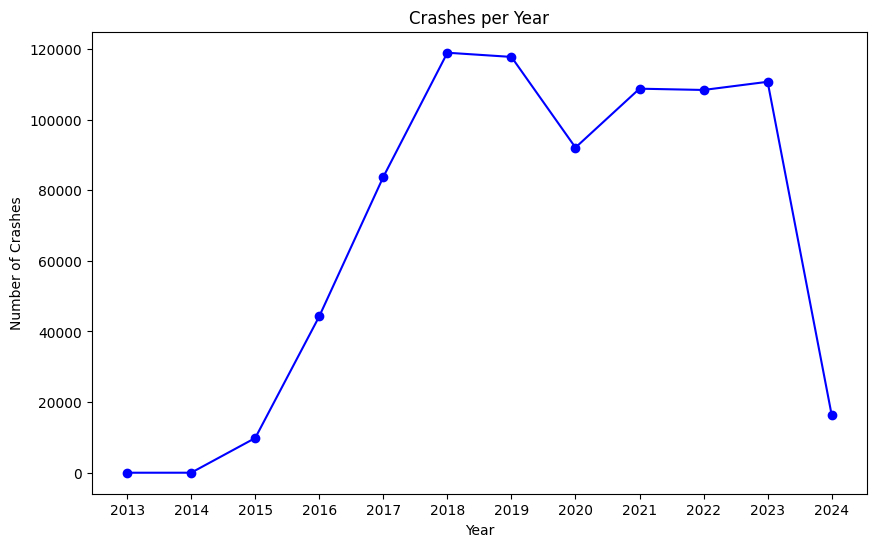

In [12]:
#~ checking the conversion
print(all_data['CRASH_DATE'].dtype)

#~ Extracting the year
if 'CRASH_YEAR' in all_data.columns:
    print('CRASH_YEAR column already exists')
else:
    all_data['CRASH_YEAR'] = all_data['CRASH_DATE'].dt.year

#~ Now we create the groupby object
crashes_per_year = all_data.groupby('CRASH_YEAR').size()

#~ Plotting the data as a line plot
crashes_per_year.plot(kind='line', marker='o', linestyle='-', color='b', figsize=(10, 6))
plt.title('Crashes per Year')
plt.xlabel('Year')
plt.xticks(crashes_per_year.index)
plt.ylabel('Number of Crashes')

plt.show()

In [13]:
#~ Checking year values
print(all_data['CRASH_YEAR'].value_counts())

CRASH_YEAR
2018    118950
2019    117762
2023    110716
2021    108764
2022    108403
2020     92092
2017     83786
2016     44297
2024     16358
2015      9829
2014         6
2013         2
Name: count, dtype: int64


###### Looking at the plot and the values in the table, we can come to certain conclusions:
- In 2013 and 2014 there are only 8 crashes in total, probably because of the lack of documentation and limited technology
- Throughout the years the number of crashes increases, with a maximum in 2018, after that the range of crashes is around 100k
- There is an important spike downward in 2020, most likely due to the COVID-19 Pandemic.

##### Line Graph of all crashes per month

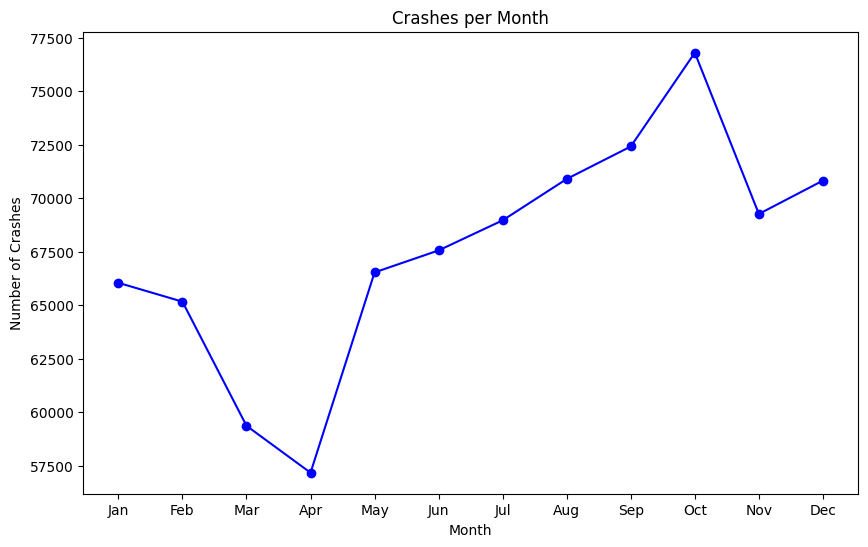

In [14]:
crashes_per_month_all = all_data.groupby('CRASH_MONTH').size()

#~ Plotting the data as a line plot
crashes_per_month_all.plot(kind='line', marker='o', linestyle='-', color='b', figsize=(10, 6))
plt.title('Crashes per Month')
plt.xlabel('Month')
plt.xticks(range(1, 13), cal.month_abbr[1:]) #~ using the calendar module to get the month abbreviations
plt.ylabel('Number of Crashes')
plt.show()

In [15]:
#~ Max and Min number of crashes per month
max_crashes_month = crashes_per_month_all.idxmax()
min_crashes_month = crashes_per_month_all.idxmin()

#~ Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

logger.info(f'Max number of crashes: {crashes_per_month_all[max_crashes_month]} in {cal.month_abbr[max_crashes_month]}')
logger.info(f'Min number of crashes: {crashes_per_month_all[min_crashes_month]} in {cal.month_abbr[min_crashes_month]}')

2024-03-14 21:45:20,650 - INFO - Max number of crashes: 76798 in Oct
2024-03-14 21:45:20,650 - INFO - Min number of crashes: 57164 in Apr


##### Line Graph of crashes in 2023

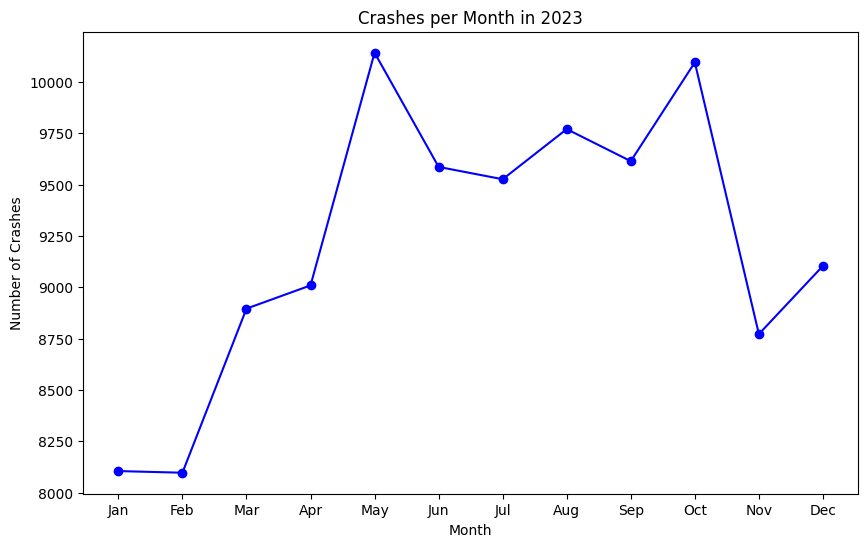

2024-03-14 21:45:20,948 - INFO - The month with the most crashes in 2023 was May with 10142 crashes
2024-03-14 21:45:20,948 - INFO - Followed by October with 10095 crashes


In [16]:
#~ 2023 crashes
crashes_2023 = all_data[all_data['CRASH_YEAR'] == 2023]

#~ Now we create the groupby object
crashes_per_month_2023 = crashes_2023.groupby('CRASH_MONTH').size() #~ size() returns the number of rows in each group

months = [cal.month_name[i] for i in crashes_per_month_2023.index]
months = [month[:3] for month in months]
#~ Plotting the data as a line plot
crashes_per_month_2023.plot(kind='line', marker='o', linestyle='-', color='b', figsize=(10, 6))
plt.title('Crashes per Month in 2023')
plt.xlabel('Month')
plt.xticks(crashes_per_month_2023.index, labels=months)
plt.ylabel('Number of Crashes')
plt.show()

best_month_name = cal.month_name[crashes_per_month_2023.idxmax()]
best_month_value = crashes_per_month_2023.max()
second_best_month_name = cal.month_name[crashes_per_month_2023.sort_values(ascending=False).index[1]]

logging.info(f'The month with the most crashes in 2023 was {best_month_name} with {best_month_value} crashes')
logging.info(f'Followed by {second_best_month_name} with {crashes_per_month_2023[crashes_per_month_2023.index == crashes_per_month_2023.sort_values(ascending=False).index[1]].values[0]} crashes')


##### Line Graph Day Of The Week

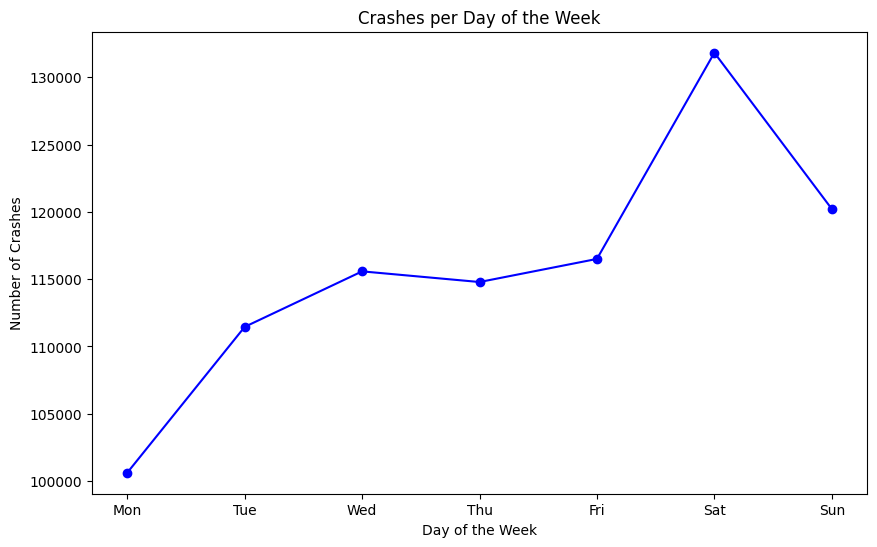

2024-03-14 21:45:21,173 - INFO - The day with the most crashes was Saturday with 131821 crashes


In [17]:
crashes_per_day_of_week = all_data.groupby('CRASH_DAY_OF_WEEK').size() #~ size() returns the number of rows in each group

#~ Plotting the data as a line plot
crashes_per_day_of_week.plot(kind='line', marker='o', linestyle='-', color='b', figsize=(10, 6))
plt.title('Crashes per Day of the Week')
plt.xlabel('Day of the Week')
plt.xticks(range(1, 8), cal.day_abbr[0:])
plt.ylabel('Number of Crashes')
plt.show()

crashes_per_day_of_week = crashes_per_day_of_week.sort_index() #~ sorting the index to get the days in order
most_crashes_day = cal.day_name[crashes_per_day_of_week.idxmax()] 
#~ cal.day_name is a list with the full names of the days of the week
#~ it is using index 7, so we need to subtract 1 from the index to get the correct day, since the index starts at 0
most_crashes_day = cal.day_name[crashes_per_day_of_week.idxmax() - 1]

logging.info(f'The day with the most crashes was {most_crashes_day} with {crashes_per_day_of_week.max()} crashes')

#### In which areas do crashes occur the most?

In [2]:
# latitude = all_data['LATITUDE']
# longitude = all_data['LONGITUDE']

# #~ Plotting the data using plotly and dash

# fig = px.scatter_mapbox(all_data, lat=latitude, lon=longitude, zoom=10) 
# #~ px.scatter_mapbox is a function from the plotly express module
# #~ it creates a scatter plot on a map
# #~ lat and lon are the latitude and longitude columns
# #~ zoom is the initial zoom level of the map
# fig = fig.update_layout(mapbox_style='open-street-map') #~ setting the map style
# fig = fig.update_layout(margin={'r': 0, 't': 0, 'l': 0, 'b': 0}) #~ setting the margins
# fig.write_image('crashes_map.png') #~ saving the plot as an image
# Tarda demasiado

NameError: name 'all_data' is not defined